In [40]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, List
from itertools import product
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
import seaborn as sns
from IPython.display import Video
import os
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from torch.utils.data import Dataset
from torch import Tensor
from abc import ABC, abstractmethod
from torch.nn.functional import relu
from torch.utils.data.dataloader import DataLoader
from tqdm.notebook import tqdm
import scipy.stats as st
from src.sde.implementations import VPSDE
from src.sde.base import ItoSDE
from backward import run_backwards

In [2]:
image_size = 28
classes_by_index  = np.arange(0,10).astype('str')

transform = transforms.Compose([transforms.Resize(image_size),\
                                transforms.ToTensor(),\
                                transforms.Normalize([0.5],[0.5])]) #Normalize to -1,1
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                    download=True, transform=transform)

batch_size = 128
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

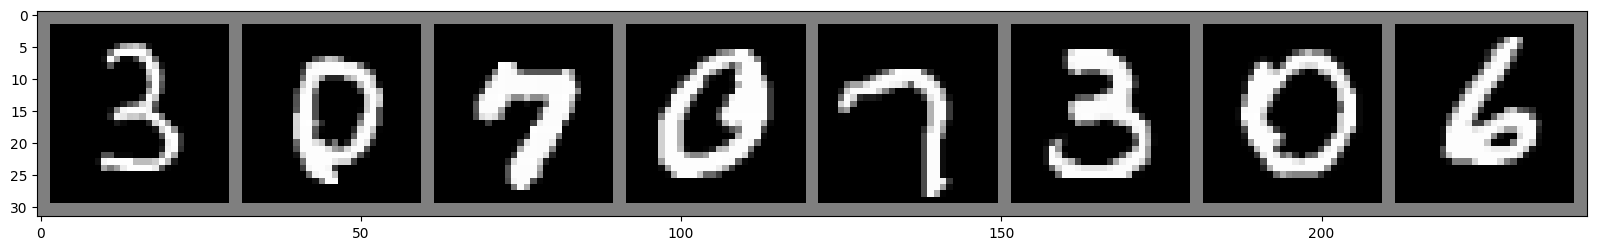

3     0     7     0     7     3     0     6    


In [3]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=[20, 20])
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
images = images[:8]
labels = labels[:8]

# show images
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes_by_index[labels[j]]:5s}' for j in range(8)))

In [4]:
sde = VPSDE(T_max=1,beta_min=0.01, beta_max=10.0)


In [5]:
sde.g_random(torch.tensor([1]))

tensor([3.1623])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4214327..2.0762765].


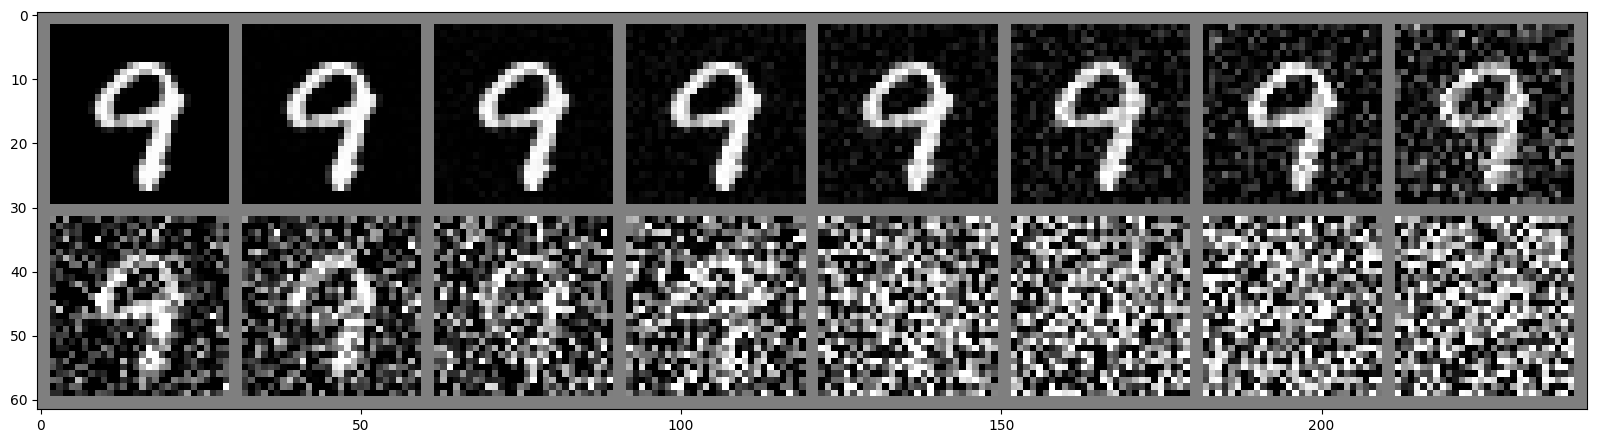

In [6]:
n_grid_points = 16
time_vec = torch.linspace(0,1,n_grid_points)**2
X_0 = torch.stack([trainset.__getitem__(23420)[0].unsqueeze(0).squeeze()]*n_grid_points)
X_t, noise, score = sde.run_forward(X_0,torch.linspace(0,1.0,n_grid_points)**2)
imshow(torchvision.utils.make_grid(X_t.unsqueeze(1)))

In [8]:
TRAIN_SCORE = False #whether to train score or denoiser network


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [10]:
class ChannelShuffle(nn.Module):
    def __init__(self,groups):
        super().__init__()
        self.groups=groups
    def forward(self,x):
        n,c,h,w=x.shape
        x=x.view(n,self.groups,c//self.groups,h,w) # group
        x=x.transpose(1,2).contiguous().view(n,-1,h,w) #shuffle
        
        return x

class ConvBnSiLu(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size,stride=1,padding=0):
        super().__init__()
        self.module=nn.Sequential(nn.Conv2d(in_channels,out_channels,kernel_size,stride=stride,padding=padding),
                                  nn.BatchNorm2d(out_channels),
                                  nn.SiLU(inplace=True))
    def forward(self,x):
        return self.module(x)

class ResidualBottleneck(nn.Module):
    '''
    shufflenet_v2 basic unit(https://arxiv.org/pdf/1807.11164.pdf)
    '''
    def __init__(self,in_channels,out_channels):
        super().__init__()

        self.branch1=nn.Sequential(nn.Conv2d(in_channels//2,in_channels//2,3,1,1,groups=in_channels//2),
                                    nn.BatchNorm2d(in_channels//2),
                                    ConvBnSiLu(in_channels//2,out_channels//2,1,1,0))
        self.branch2=nn.Sequential(ConvBnSiLu(in_channels//2,in_channels//2,1,1,0),
                                    nn.Conv2d(in_channels//2,in_channels//2,3,1,1,groups=in_channels//2),
                                    nn.BatchNorm2d(in_channels//2),
                                    ConvBnSiLu(in_channels//2,out_channels//2,1,1,0))
        self.channel_shuffle=ChannelShuffle(2)

    def forward(self,x):
        x1,x2=x.chunk(2,dim=1)
        x=torch.cat([self.branch1(x1),self.branch2(x2)],dim=1)
        x=self.channel_shuffle(x) #shuffle two branches

        return x

class ResidualDownsample(nn.Module):
    '''
    shufflenet_v2 unit for spatial down sampling(https://arxiv.org/pdf/1807.11164.pdf)
    '''
    def __init__(self,in_channels,out_channels):
        super().__init__()
        self.branch1=nn.Sequential(nn.Conv2d(in_channels,in_channels,3,2,1,groups=in_channels),
                                    nn.BatchNorm2d(in_channels),
                                    ConvBnSiLu(in_channels,out_channels//2,1,1,0))
        self.branch2=nn.Sequential(ConvBnSiLu(in_channels,out_channels//2,1,1,0),
                                    nn.Conv2d(out_channels//2,out_channels//2,3,2,1,groups=out_channels//2),
                                    nn.BatchNorm2d(out_channels//2),
                                    ConvBnSiLu(out_channels//2,out_channels//2,1,1,0))
        self.channel_shuffle=ChannelShuffle(2)

    def forward(self,x):
        x=torch.cat([self.branch1(x),self.branch2(x)],dim=1)
        x=self.channel_shuffle(x) #shuffle two branches

        return x

class TimeMLP(nn.Module):
    '''
    naive introduce timestep information to feature maps with mlp and add shortcut
    '''
    def __init__(self,embedding_dim,hidden_dim,out_dim):
        super().__init__()
        self.mlp=nn.Sequential(nn.Linear(embedding_dim,hidden_dim),
                                nn.SiLU(),
                               nn.Linear(hidden_dim,out_dim))
        self.act=nn.SiLU()
    def forward(self,x,t):
        t_emb=self.mlp(t).unsqueeze(-1).unsqueeze(-1)
        x=x+t_emb
  
        return self.act(x)
    
class EncoderBlock(nn.Module):
    def __init__(self,in_channels,out_channels,time_embedding_dim):
        super().__init__()
        self.conv0=nn.Sequential(*[ResidualBottleneck(in_channels,in_channels) for i in range(3)],
                                    ResidualBottleneck(in_channels,out_channels//2))

        self.time_mlp=TimeMLP(embedding_dim=time_embedding_dim,hidden_dim=out_channels,out_dim=out_channels//2)
        self.conv1=ResidualDownsample(out_channels//2,out_channels)
    
    def forward(self,x,t=None):
        x_shortcut=self.conv0(x)
        if t is not None:
            x=self.time_mlp(x_shortcut,t)
        x=self.conv1(x)

        return [x,x_shortcut]
        
class DecoderBlock(nn.Module):
    def __init__(self,in_channels,out_channels,time_embedding_dim):
        super().__init__()
        self.upsample=nn.Upsample(scale_factor=2,mode='bilinear',align_corners=False)
        self.conv0=nn.Sequential(*[ResidualBottleneck(in_channels,in_channels) for i in range(3)],
                                    ResidualBottleneck(in_channels,in_channels//2))

        self.time_mlp=TimeMLP(embedding_dim=time_embedding_dim,hidden_dim=in_channels,out_dim=in_channels//2)
        self.conv1=ResidualBottleneck(in_channels//2,out_channels//2)

    def forward(self,x,x_shortcut,t=None):
        x=self.upsample(x)
        x=torch.cat([x,x_shortcut],dim=1)
        x=self.conv0(x)
        if t is not None:
            x=self.time_mlp(x,t)
        x=self.conv1(x)

        return x        

class Unet(nn.Module):
    '''
    simple unet design without attention
    '''
    def __init__(self,timesteps,time_embedding_dim,in_channels=3,out_channels=2,base_dim=32,dim_mults=[2,4,8,16], temp: float = 20.0):
        super().__init__()
        assert isinstance(dim_mults,(list,tuple))
        assert base_dim%2==0 

        channels=self._cal_channels(base_dim,dim_mults)

        self.init_conv=ConvBnSiLu(in_channels,base_dim,3,1,1)
        #self.time_embedding=nn.Embedding(timesteps,time_embedding_dim)
        self.time_embedding=nn.Linear(timesteps,time_embedding_dim)

        self.encoder_blocks=nn.ModuleList([EncoderBlock(c[0],c[1],time_embedding_dim) for c in channels])
        self.decoder_blocks=nn.ModuleList([DecoderBlock(c[1],c[0],time_embedding_dim) for c in channels[::-1]])
    
        self.mid_block=nn.Sequential(*[ResidualBottleneck(channels[-1][1],channels[-1][1]) for i in range(2)],
                                        ResidualBottleneck(channels[-1][1],channels[-1][1]//2))

        self.final_conv=nn.Conv2d(in_channels=channels[0][0]//2,out_channels=out_channels,kernel_size=1)

        self.centers = nn.Parameter(torch.linspace(0,1,timesteps+1)[:-1]+0.5/timesteps,requires_grad=False)
        self.temp = temp
        

    def get_softmax(self, t):
        softmax_mat = F.softmax(-self.temp*torch.abs(t[:,None]-self.centers[None,:]), dim=1)
        return softmax_mat
        
    def get_time_emb(self,t):
        softmax_mat = self.get_softmax(t)
        t=self.time_embedding(softmax_mat)
    
        return t
        
    def forward(self,x,t=None):
        
        x=self.init_conv(x)
        
        if t is not None:
            t = self.get_time_emb(t)
            
        encoder_shortcuts=[]
        for encoder_block in self.encoder_blocks:
            x,x_shortcut=encoder_block(x,t)
            encoder_shortcuts.append(x_shortcut)
        x=self.mid_block(x)
        encoder_shortcuts.reverse()
        for decoder_block,shortcut in zip(self.decoder_blocks,encoder_shortcuts):
            x=decoder_block(x,shortcut,t)
        x=self.final_conv(x)

        return x

    def _cal_channels(self,base_dim,dim_mults):
        dims=[base_dim*x for x in dim_mults]
        dims.insert(0,base_dim)
        channels=[]
        for i in range(len(dims)-1):
            channels.append((dims[i],dims[i+1])) # in_channel, out_channel

        return channels

In [11]:
def train_diffusion_model(model, sde: ItoSDE, dataloader: DataLoader, optimizer, device, n_epochs: int, print_every: int, train_score: bool = TRAIN_SCORE,WEIGHT_DECAY: float = 0,scheduler=None):
    model.train()
    model = model.to(device)
    loss_function = nn.MSELoss(reduction='mean')
    running_loss_list = []

    for epoch in range(n_epochs):
        print(f"Epoch: {epoch}")
        running_loss = 0.0
        for idx, (x_inp,y_inp) in enumerate(dataloader):

            #Zero gradients:
            optimizer.zero_grad()

            #Run forward samples:
           
            X_t,noise,score,time = sde.run_forward_random_times(x_inp)

            #Send to device:
            X_t = X_t.to(device)
            noise = noise.to(device)
            score = score.to(device)
            time = time.to(device)

            #Predict score:
            model_pred = model(X_t,time)

            #Compute loss:
            if train_score:
                loss = loss_function(score,model_pred)
            else:
                loss = loss_function(noise,model_pred)

            #Optimize:
            loss.backward()
            optimizer.step()
            if scheduler is not None:
                scheduler.step()

            # print statistics
            running_loss += loss.detach().item()

            if (idx+1) % print_every == 0:
                avg_loss = running_loss/print_every
                running_loss_list.append(avg_loss)
                running_loss = 0.0
                print(avg_loss)
    return model,running_loss_list

In [12]:
N_TIMESTEPS = 100
n_channels = 1

model = Unet(base_dim=image_size, in_channels=n_channels, out_channels=n_channels, time_embedding_dim=256, timesteps=N_TIMESTEPS, dim_mults=[2, 4], temp=100.0)
model = torch.compile(model)

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"


In [14]:
LEARNING_RATE = 1e-2 #2e-5
WEIGHT_DECAY = 0.0
N_EPOCHS = 100
RETRAIN = True

if RETRAIN:
    optimizer = torch.optim.AdamW(model.parameters(),lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY,maximize=False)
    scheduler=torch.optim.lr_scheduler.OneCycleLR(optimizer,LEARNING_RATE,total_steps=N_EPOCHS*len(trainloader),pct_start=0.25,anneal_strategy='cos')
    
    model,running_loss_list = train_diffusion_model(model, sde, trainloader, train_score=TRAIN_SCORE, optimizer=optimizer, scheduler=scheduler, device=device, n_epochs=N_EPOCHS, print_every=100)
    torch.save(model.state_dict(),"20231120_mnist_diffusion_denoiser.ckpt")
    
else:
    model_state_dict = torch.load("20231120_mnist_diffusion_denoiser.ckpt")
    model.load_state_dict(model_state_dict)

Epoch: 0


/home/ashwathshetty/miniconda3/envs/di/lib/python3.10/site-packages/torch/_inductor/compile_fx.py:194: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(


0.8316672146320343
0.48653027206659316
0.3198662206530571
0.2336205105483532
Epoch: 1
0.15545520916581154
0.13155681774020195
0.11385412558913231
0.10264711640775204
Epoch: 2
0.08678283832967282
0.07955983594059944
0.07466429062187671
0.07106919109821319
Epoch: 3
0.06622795723378658
0.06313307978212833
0.061605386212468145
0.05860930230468511
Epoch: 4
0.05613487705588341
0.05667979165911675
0.054857138432562354
0.05186505045741797
Epoch: 5
0.051392340399324894
0.04968487411737442
0.04936529602855444
0.04696597818285227
Epoch: 6
0.04629789639264345
0.0464681838452816
0.046702938228845595
0.04402453422546387
Epoch: 7
0.045269384272396566
0.04500257637351751
0.04494409620761872
0.04399637740105391
Epoch: 8
0.04313726149499417
0.04609007120132446
0.04399962317198515
0.044811410568654536
Epoch: 9
0.0424031600356102
0.04180901233106851
0.04214465770870447
0.04174722190946341
Epoch: 10
0.04122839745134115
0.04174233442172408
0.04240934807807207
0.04134099174290896
Epoch: 11
0.0413654593005776

In [33]:
def run_backwards2(model: torch.nn.Module, sde: ItoSDE, x_start: Tensor, device, train_score, n_steps: int = 10, plot_evolution: bool = True, clip_max: float = 1.0, clip_min: float = -1.0, **kwargs):
    """Function to run stochastic differential equation. We assume a deterministic initial distribution p_0."""
    model = model.to(device)
    model.eval()
    #Number of trajectories, dimension of data:
    n_traj = x_start.shape[0]
    ndim = x_start.dim()-1

    #Compute time grid for discretization and step size:
    time_grid = torch.linspace(sde.T_max,0,n_steps)
    step_size =torch.abs(time_grid[0]-time_grid[1])

    #Compute the random drift at every time point:
    random_drift_grid = sde.g_random(time_grid)

    #Sample random drift at every time point:
    noise = torch.randn(size=(n_steps,*list(x_start.shape)))
    random_drift_grid_sample = torch.sqrt(step_size) * noise * random_drift_grid.view(-1,*[1]*(ndim+1))

    #Initialize list of trajectory:
    x_traj = [x_start]

    if plot_evolution:
        fig, axs = plt.subplots(1,len(time_grid),figsize=(6*len(time_grid),6))


    for idx,time in tqdm(enumerate(time_grid)):

        #Get last location and time
        x = x_traj[idx]
        t = time_grid[idx]
        time_vec = t.repeat(n_traj)

        #Deterministic drift: f(X_,t)
        determ_drift = step_size*sde.f_drift(x,time_vec)

        #Get random drift:
        random_drift_sample = random_drift_grid_sample[idx]

        #Get noise estimates:
        model_estimate = model(x.to(device),time_vec.to(device)).detach().cpu()

        if train_score:
            score_estimates = model_estimate
        else:
            denominator = torch.clip(sde.cond_std(None, time_vec),0.01)
            if len(model_estimate.shape) == 4:
                score_estimates = -model_estimate/denominator[:,None,None,None]
            else:
                score_estimates = -model_estimate/denominator[:,None]

        #Correction term: g^2 * score estimate
        g_squared = (random_drift_grid[idx]**2).repeat(n_traj)
        correction_term = (step_size*ItoSDE._mult_first_dim(g_squared,score_estimates))

        #Compute next step:
        change = (correction_term - determ_drift) + random_drift_sample
        next_step = x + change

        #Save step:
        x_traj.append(next_step)

        if plot_evolution:
            axs[idx].scatter(next_step[:,0],next_step[:,1])
            axs[idx].quiver(next_step[:,0],next_step[:,1],change[:,0],change[:,1])
            axs[idx].set_xlim(-2.0,2.0)
            axs[idx].set_ylim(-2.0,2.0)
            axs[idx].set_title(f"Step={idx}")
    plt.show()
    output = torch.stack(x_traj) #.transpose(1,0)
    #output = torch.clip(output, clip_min, clip_max)
    return output,time_grid

In [37]:
model = model.to(device)
x_start = torch.clip(torch.randn(size=next(iter(trainloader))[0].shape)[:64],-1.0,1.0)
output,time_grid = run_backwards2(model,sde,x_start=x_start,n_steps=10,device=device,train_score=TRAIN_SCORE, clip_min=-10.0, clip_max=10.0,plot_evolution=False)

0it [00:00, ?it/s]

In [38]:
output.shape

torch.Size([11, 64, 1, 28, 28])

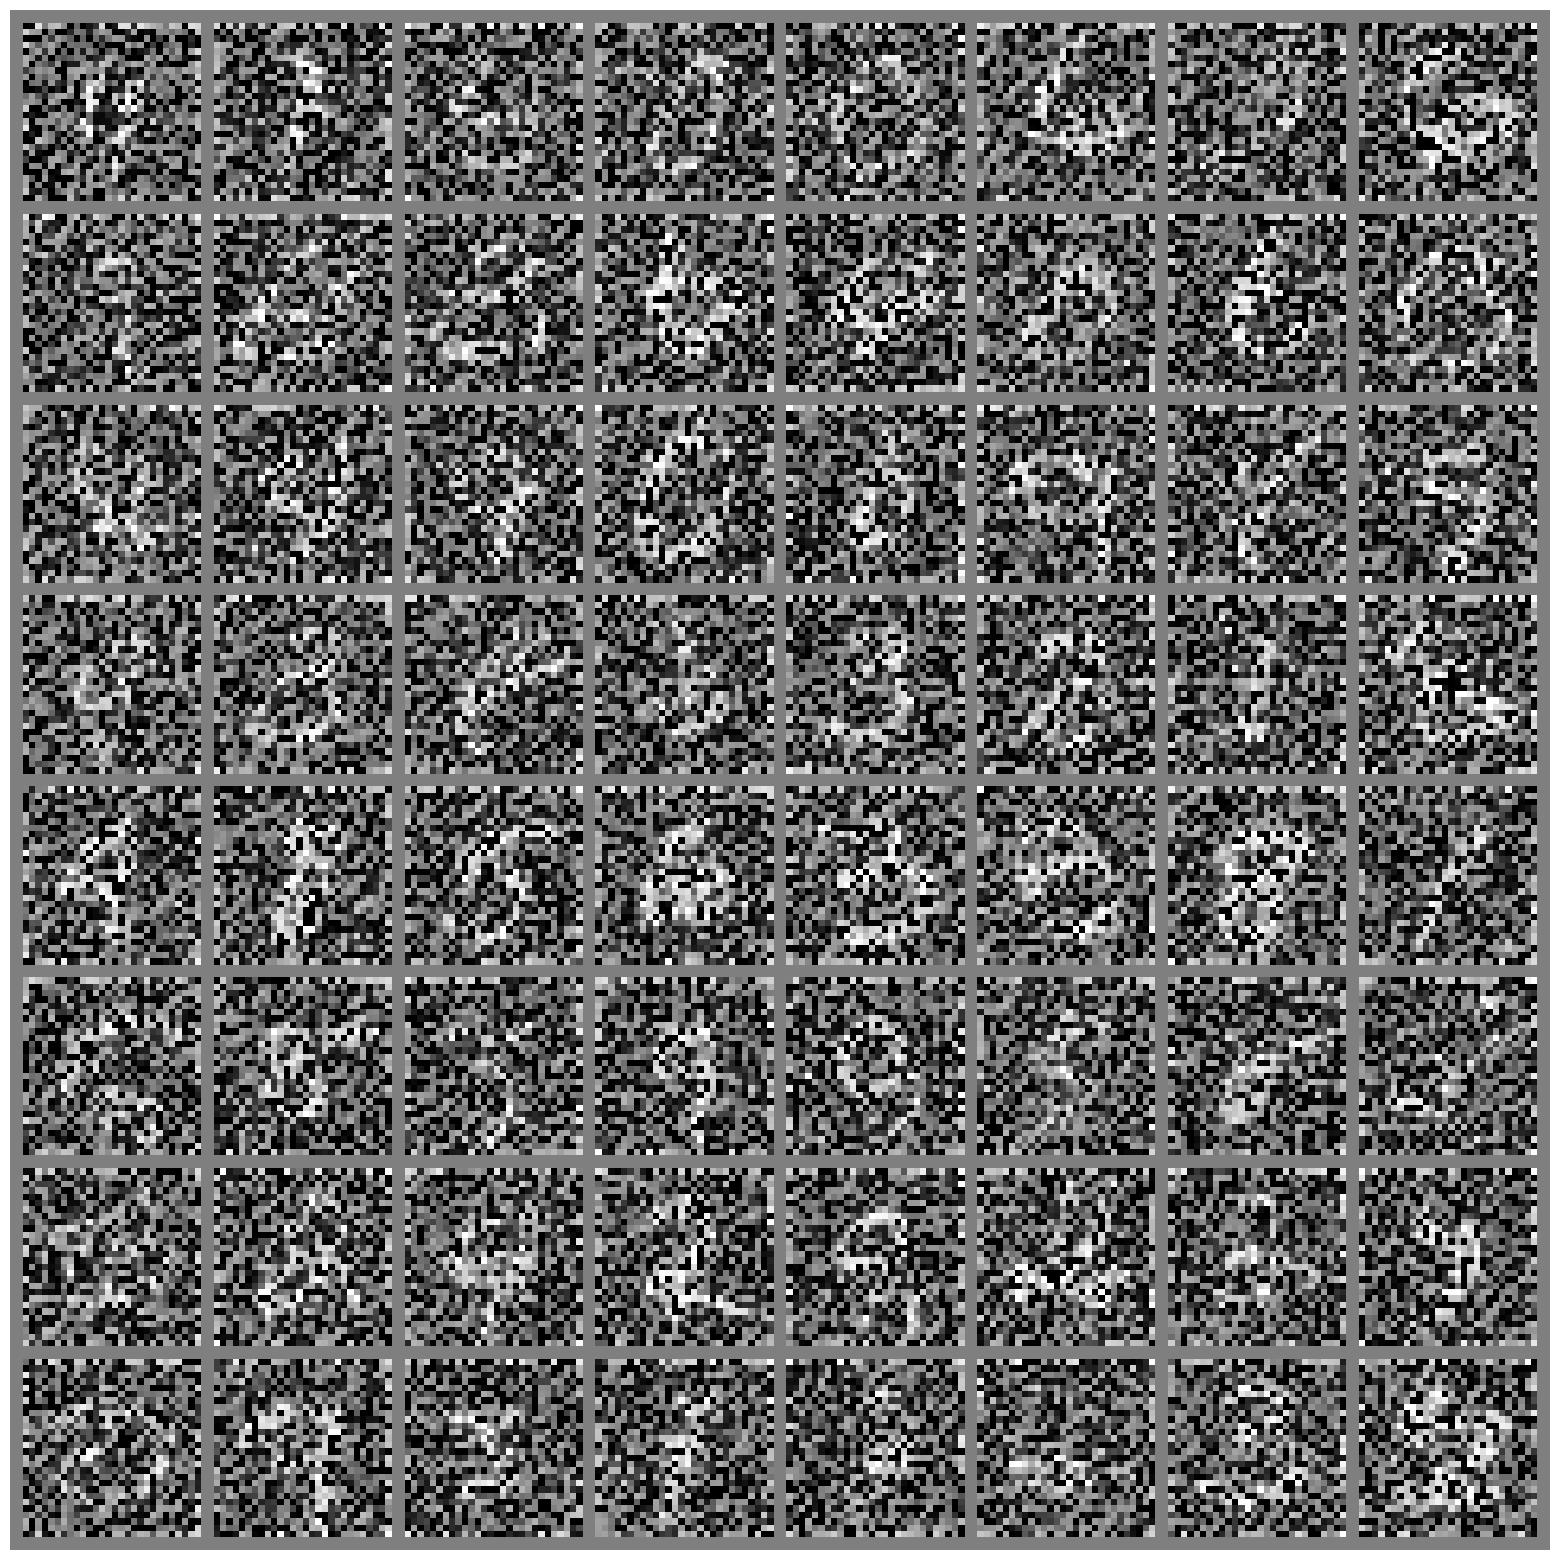

In [39]:
def imshow(img):
    img = (img + 1)/2     # normalize from [-1,1] to [0,1]
    img = torch.clamp(img, 0, 1)  # ensure values are in valid range
    npimg = img.numpy()
    plt.figure(figsize=[20, 20])
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')  # hide axes
    plt.show()

# When displaying the output:
imshow(torchvision.utils.make_grid(output[-1])) 

In [42]:
model = model.to(device)
x_start = torch.clip(torch.randn(size=next(iter(trainloader))[0].shape)[:64],-1.0,1.0)
output,time_grid = run_backwards(model,sde,x_start=x_start,n_steps=500,device=device,train_score=TRAIN_SCORE, clip_min=-10.0, clip_max=10.0,plot_evolution=False)

500it [00:02, 229.41it/s]


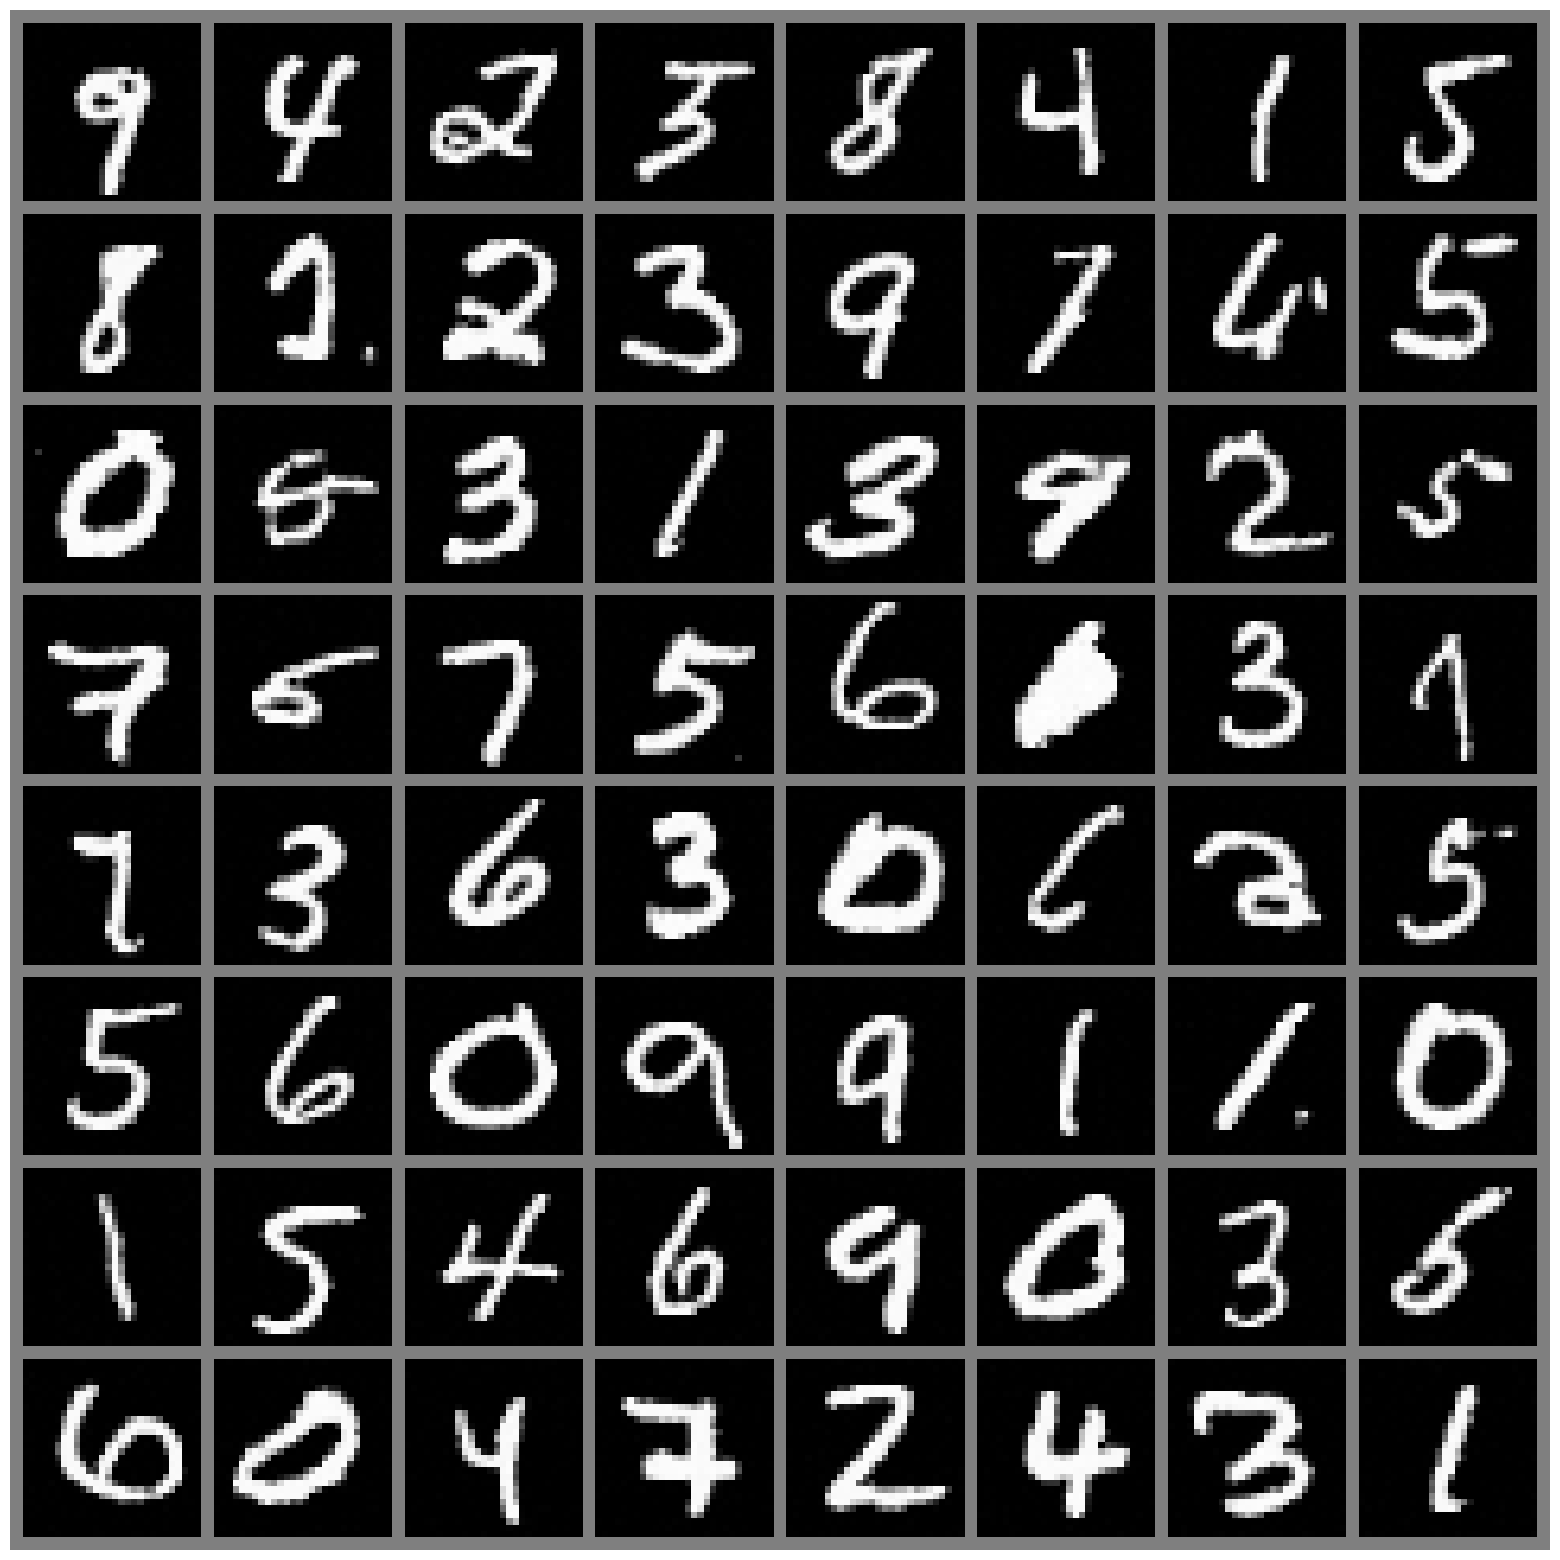

In [43]:
def imshow(img):
    img = (img + 1)/2     # normalize from [-1,1] to [0,1]
    img = torch.clamp(img, 0, 1)  # ensure values are in valid range
    npimg = img.numpy()
    plt.figure(figsize=[20, 20])
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')  # hide axes
    plt.show()

# When displaying the output:
imshow(torchvision.utils.make_grid(output[-1])) 

In [44]:
model = model.to(device)
x_start = torch.clip(torch.randn(size=next(iter(trainloader))[0].shape)[:64],-1.0,1.0)
output,time_grid = run_backwards(model,sde,x_start=x_start,n_steps=100,device=device,train_score=TRAIN_SCORE, clip_min=-10.0, clip_max=10.0,plot_evolution=False)

100it [00:00, 274.89it/s]


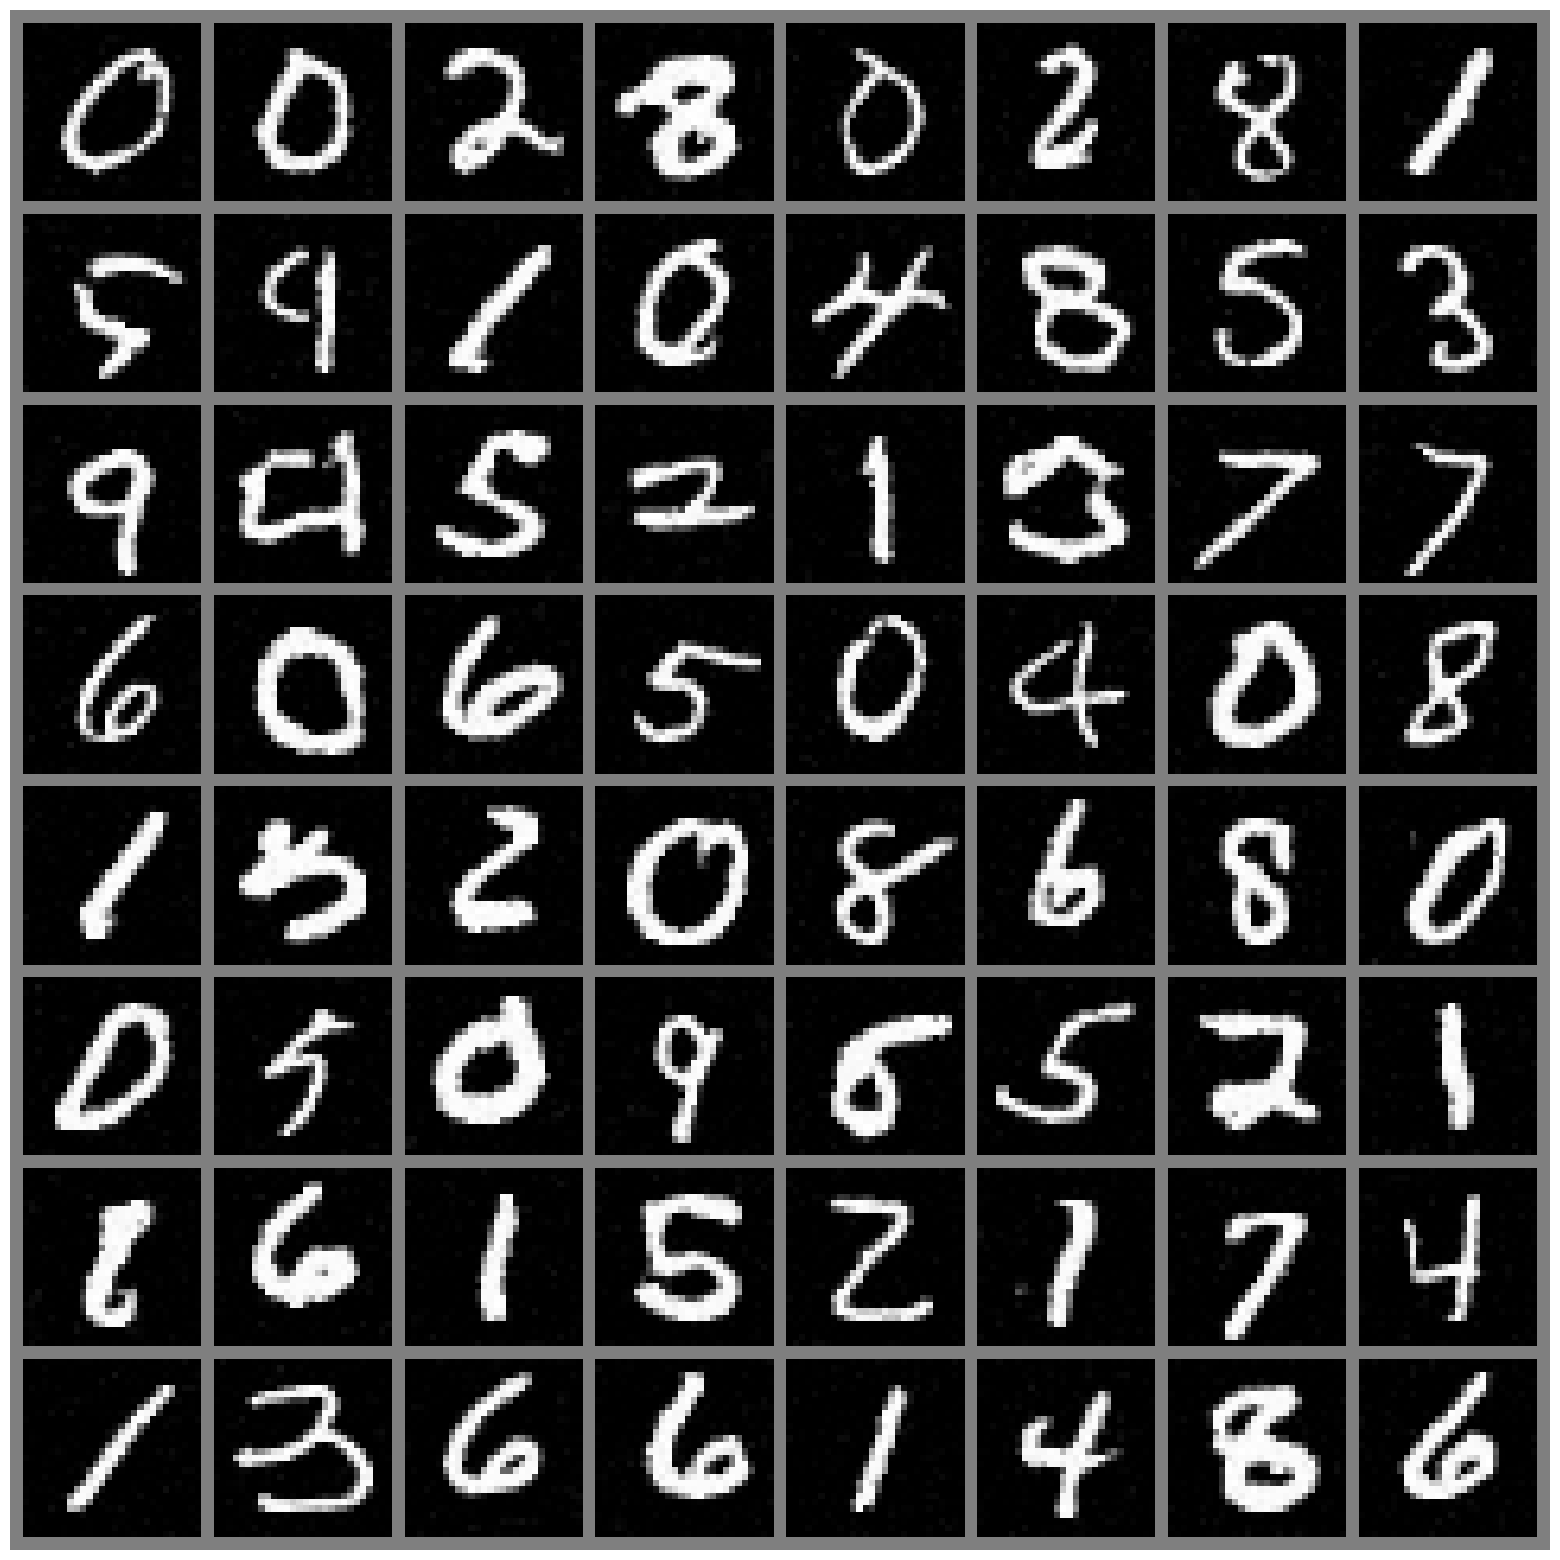

In [45]:
def imshow(img):
    img = (img + 1)/2     # normalize from [-1,1] to [0,1]
    img = torch.clamp(img, 0, 1)  # ensure values are in valid range
    npimg = img.numpy()
    plt.figure(figsize=[20, 20])
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')  # hide axes
    plt.show()

# When displaying the output:
imshow(torchvision.utils.make_grid(output[-1])) 

In [46]:
model = model.to(device)
x_start = torch.clip(torch.randn(size=next(iter(trainloader))[0].shape)[:64],-1.0,1.0)
output,time_grid = run_backwards(model,sde,x_start=x_start,n_steps=50,device=device,train_score=TRAIN_SCORE, clip_min=-10.0, clip_max=10.0,plot_evolution=False)

50it [00:00, 127.29it/s]


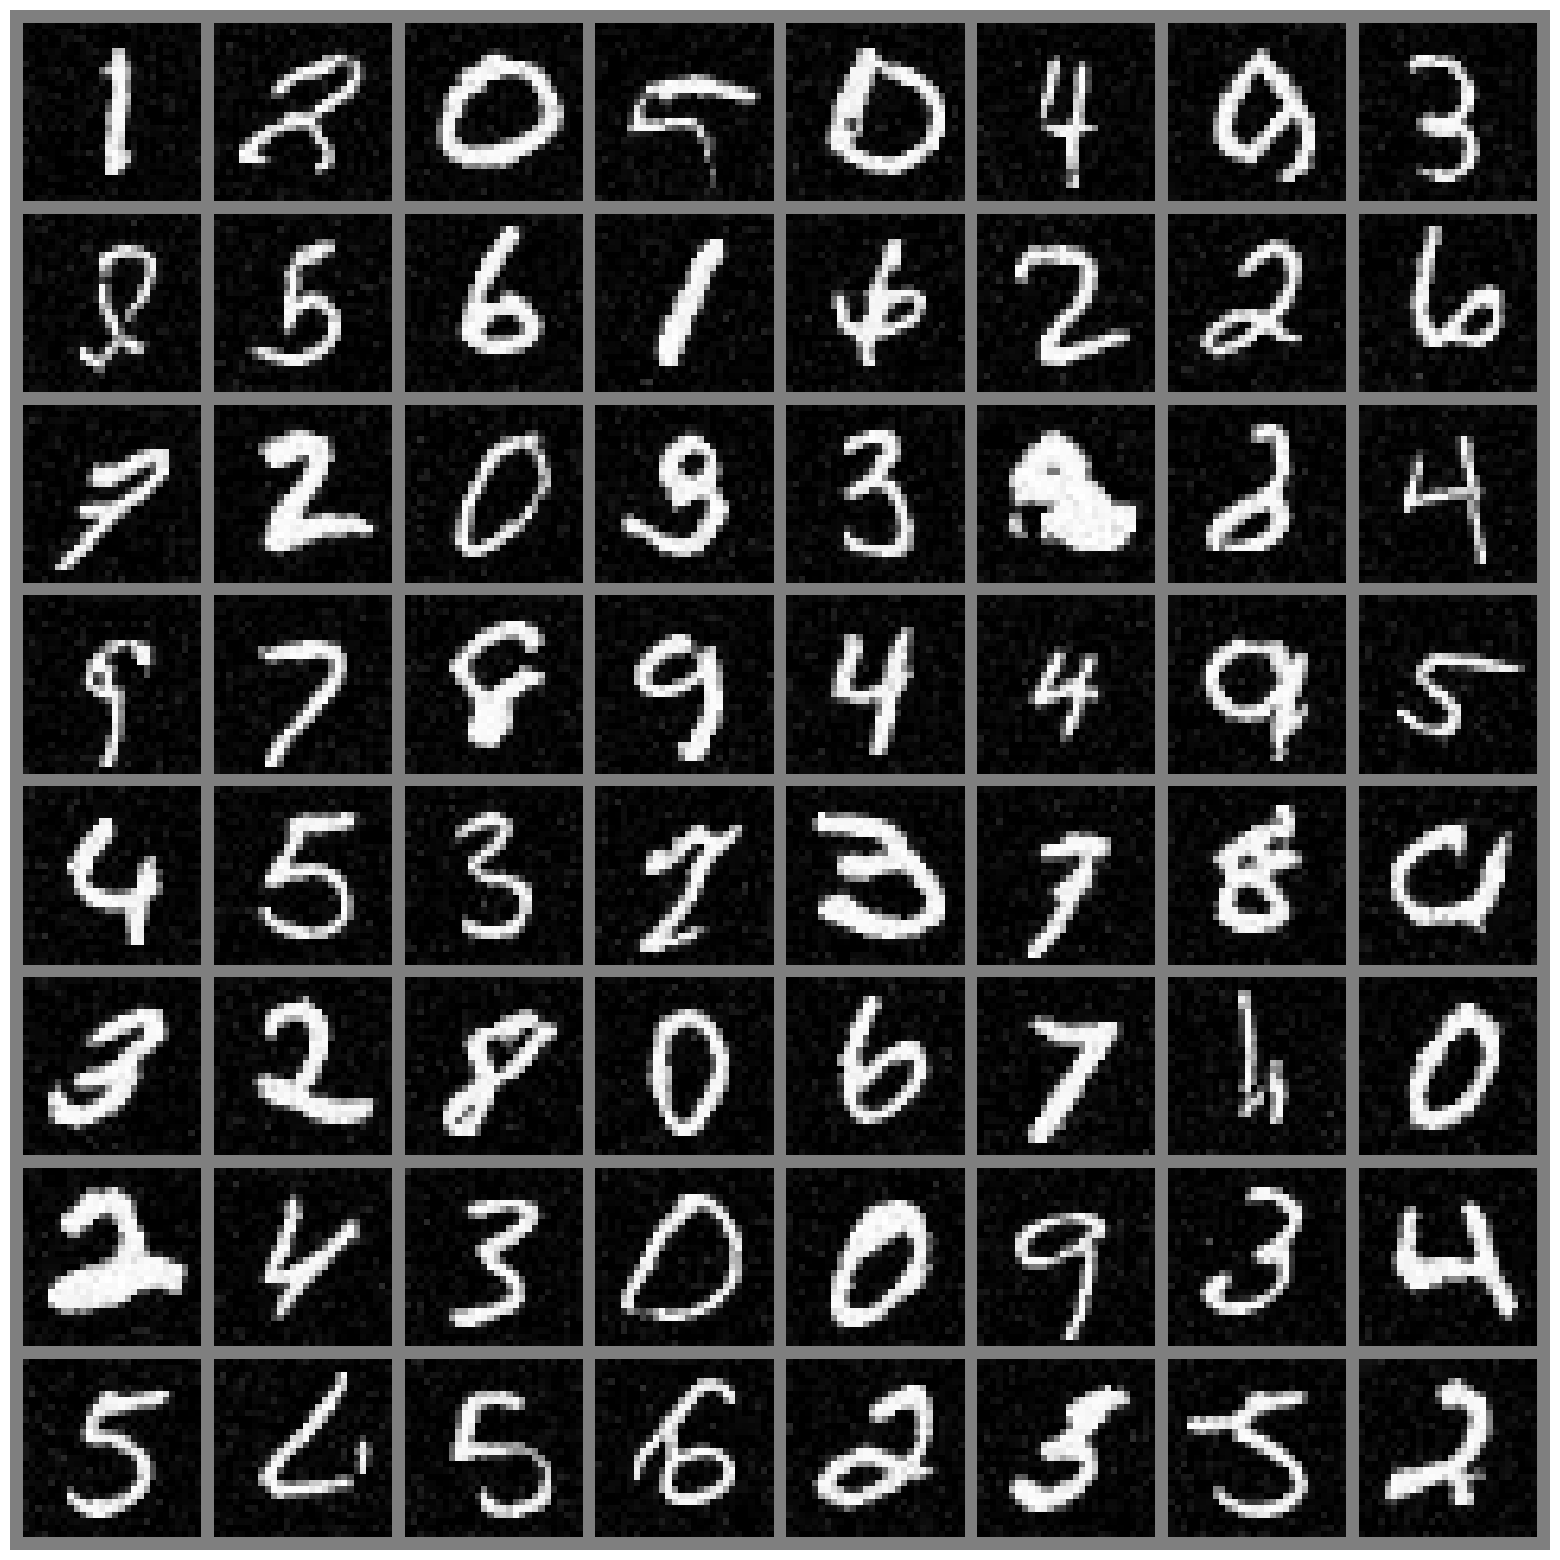

In [47]:
imshow(torchvision.utils.make_grid(output[-1])) 

In [48]:
model = model.to(device)
x_start = torch.clip(torch.randn(size=next(iter(trainloader))[0].shape)[:64],-1.0,1.0)
output,time_grid = run_backwards(model,sde,x_start=x_start,n_steps=10,device=device,train_score=TRAIN_SCORE, clip_min=-10.0, clip_max=10.0,plot_evolution=False)

10it [00:00, 166.10it/s]


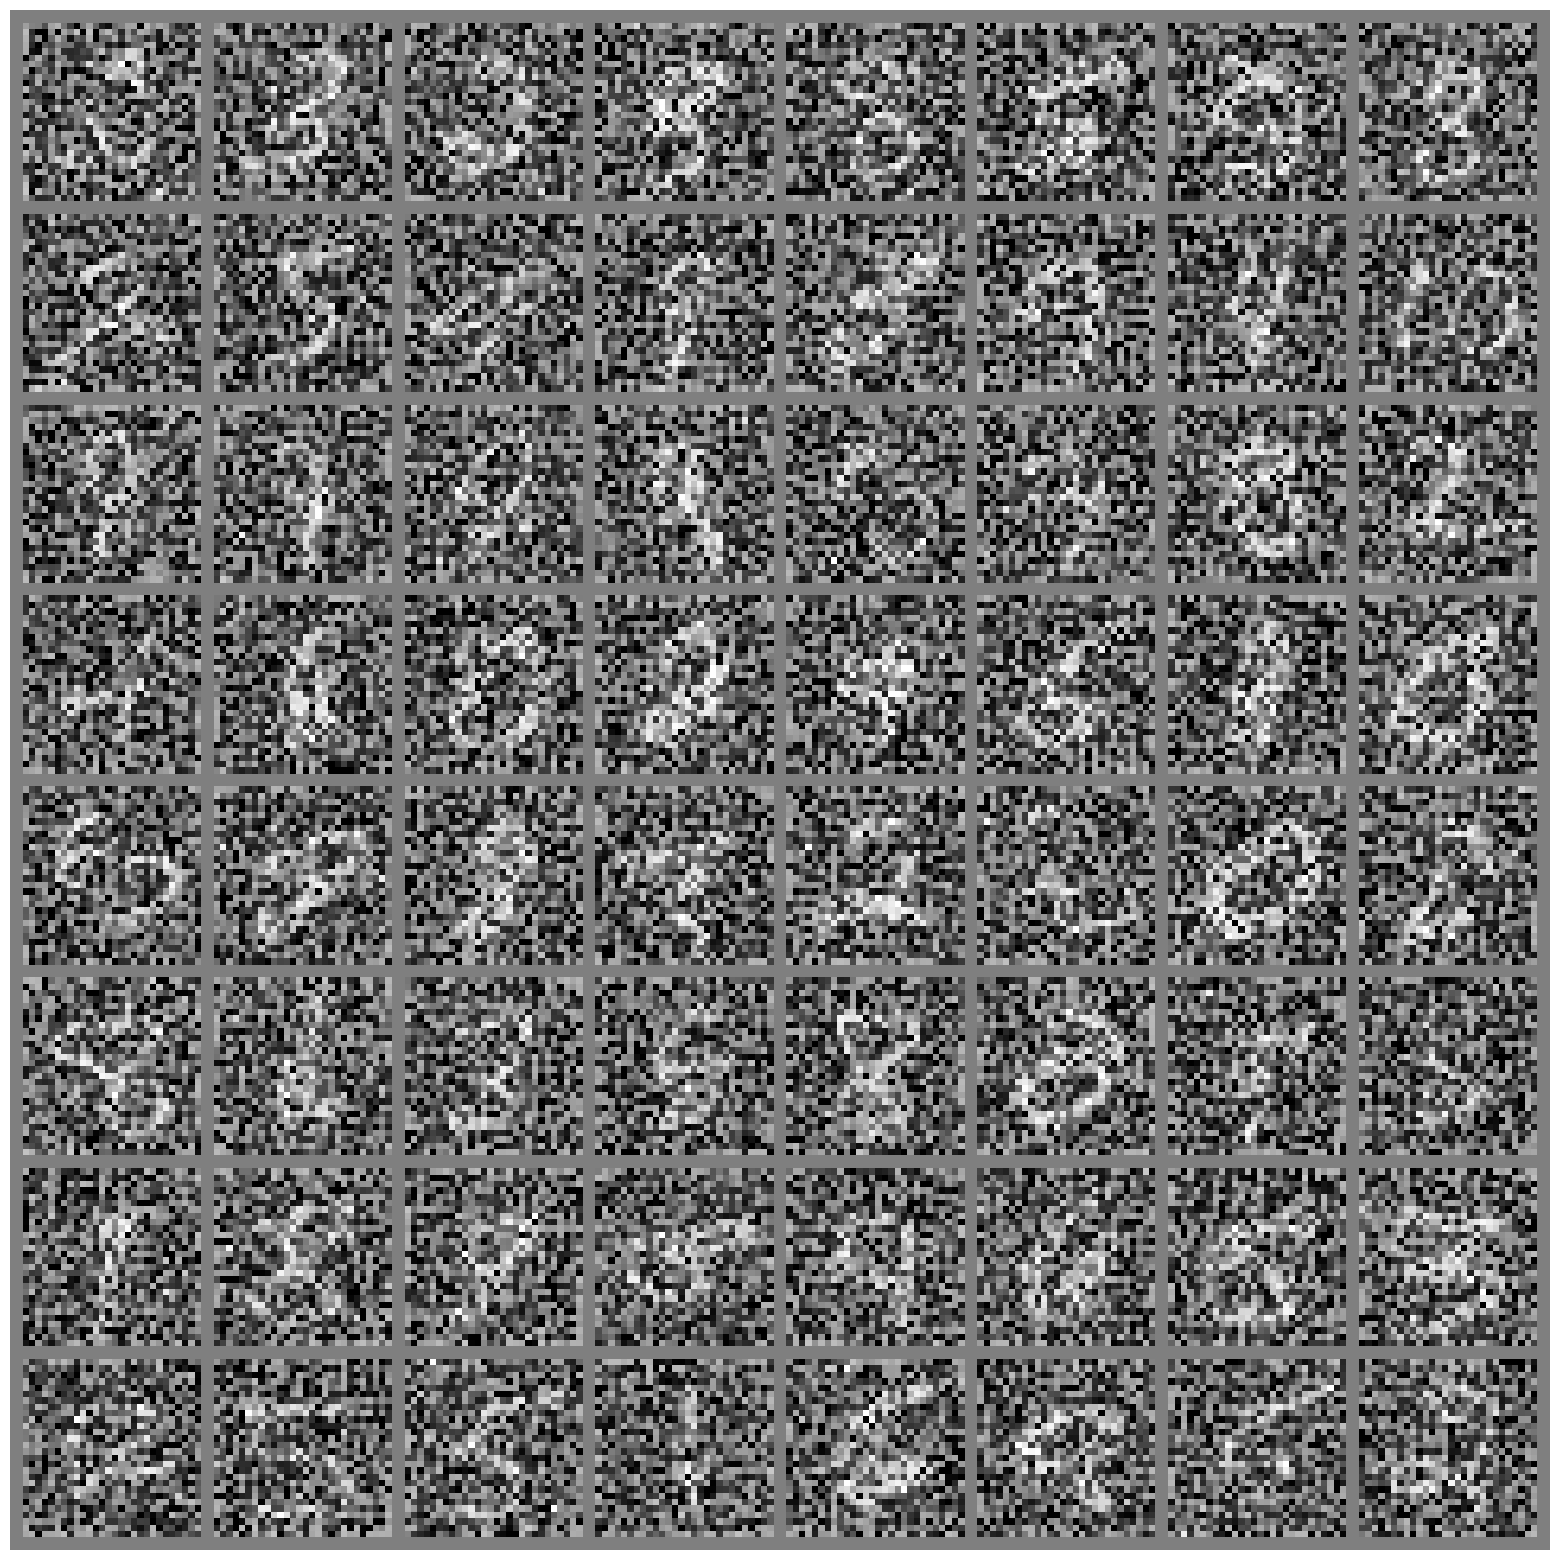

In [49]:
imshow(torchvision.utils.make_grid(output[-1]))